In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
%matplotlib inline

from utils import ChiMerge_MaxInterval_Original, CalcWOE, AssignBin, calcCut
from model_test import *

### ChiMerge_MaxInterval_Original 初分箱后，人工合并

In [2]:
data = pd.read_csv('data/贷中数据2.csv', engine='python')
data1 = data.copy()

In [3]:
# 跟据bad_pct 单调性， 分箱占比，iv人工优化后的分箱指标
cutpoint = {
    'quota': [19700, 24800, 30000, 49700],
    'ratio_interest_loan': [0.1, 0.3],
    'pct_pre_repay': [0.4, 0.5, 0.7, 0.9],
    'repay_nums_overdue': [4, 6, 10, 22],
#     'pct_due_repay': [0.1, 0.5, 0.6, 0.9],  和pct_pre_repay强相关
    'repay_nums_pre': [1, 10, 17, 45],
    'ratio_interest_loan': [0.3],
    'repay_nums_due': [1, 7, 36],
    'ratio_loan_quota': [1.9, 2, 4.6],
    'M0_nums': [1, 2, 3, 5],
    'pct_morning_repay': [0.1, 0.4, 0.9],
    'pct_night_repay': [0.2, 0.4, 0.5, 0.9],
    'repay_nums_Dawn': [2,3,6,10,14],
    'life_long_days': [130, 281, 431,561],
    'pct_afternoon_loan': [0.1, 0.4, 0.9],
    
}

In [4]:
# 看一下相关性
data1[list(cutpoint.keys())].corr()

,quota,ratio_interest_loan,pct_pre_repay,repay_nums_overdue,repay_nums_pre,repay_nums_due,ratio_loan_quota,M0_nums,pct_morning_repay,pct_night_repay,repay_nums_Dawn,life_long_days,pct_afternoon_loan
quota,1.000000,-0.304600,0.144624,-0.120587,0.158804,0.037360,-0.089064,-0.134058,-0.003605,0.015797,0.002838,-0.201019,0.032340
ratio_interest_loan,-0.304600,1.000000,-0.588439,0.410528,-0.035202,0.461008,0.091888,0.300626,0.178177,-0.134963,0.159517,0.377023,-0.018409
pct_pre_repay,0.144624,-0.588439,1.000000,-0.303638,0.403679,-0.380089,0.367322,-0.235633,-0.486391,0.348053,-0.020157,-0.106745,0.003294
repay_nums_overdue,-0.120587,0.410528,-0.303638,1.000000,0.007936,0.311583,-0.063256,0.561988,-0.056856,-0.022877,0.348971,0.199838,-0.023999
repay_nums_pre,0.158804,-0.035202,0.403679,0.007936,1.000000,0.311536,0.571387,-0.069031,-0.189668,0.180299,0.324392,0.191168,-0.022485
repay_nums_due,0.037360,0.461008,-0.380089,0.311583,0.311536,1.000000,0.006599,0.171884,0.256363,-0.128703,0.303000,0.285334,-0.031687
ratio_loan_quota,-0.089064,0.091888,0.367322,-0.063256,0.571387,0.006599,1.000000,-0.055994,-0.241998,0.200713,0.082353,0.132597,0.001566
M0_nums,-0.134058,0.300626,-0.235633,0.561988,-0.069031,0.171884,-0.055994,1.000000,-0.010177,-0.036481,0.140785,0.088001,-0.019233
pct_morning_repay,-0.003605,0.178177,-0.486391,-0.056856,-0.189668,0.256363,-0.241998,-0.010177,1.000000,-0.532492,-0.084193,-0.086547,-0.054937
pct_night_repay,0.015797,-0.134963,0.348053,-0.022877,0.180299,-0.128703,0.200713,-0.036481,-0.532492,1.000000,-0.000304,0.107941,-0.027190


In [5]:
woe_dfs = []  # 字段的woe及详情， dataframe
discrete_dfs = []  # cut后的离散表
woe_dict = {}  # 字段的woe， dict， 便于转换
for c, p in cutpoint.items():
    df_woe_info, df_woe_cut = calcCut(data1, c, 'isBad', p, 'dataframe')
    dict_woe_info, _ = calcCut(data1, c, 'isBad', p, 'dict')
    
    df_woe_info['var_name'] = c
    woe_dfs.append(df_woe_info)
    
    woe_dict[c] = dict_woe_info
    # df_woe_cut 中有isBad 先删除
    df_woe_cut = df_woe_cut.drop(['isBad'], axis=1)  # 按行拼接
    discrete_dfs.append(df_woe_cut)  # 按列拼接

In [6]:
woe_info = pd.concat(woe_dfs)

In [7]:
discrete_data = pd.concat(discrete_dfs,axis=1)
discrete_data['isBad'] = data1['isBad']
discrete_data['customer_id'] = data1['customer_id']

In [8]:
woe_dict['life_long_days']

{'CUTPOINTS': [0, 130, 281, 431, 561, inf],
 'IV': 0.022600086369981436,
 'WOE': {'(0, 130)': {'WOE': 0.36107623120658966},
  '(130, 281)': {'WOE': -0.020486590012880106},
  '(281, 431)': {'WOE': -0.14825956034619181},
  '(431, 561)': {'WOE': -0.024682398586532157},
  '(561, inf)': {'WOE': -0.015334996652371294}}}

In [9]:
discrete_data.to_csv('DATA_DISCRETE.csv', index=False)

In [10]:
discrete_data.head()  # 用于转换成woe值

,quota_Bins,ratio_interest_loan_Bins,pct_pre_repay_Bins,repay_nums_overdue_Bins,repay_nums_pre_Bins,repay_nums_due_Bins,ratio_loan_quota_Bins,M0_nums_Bins,pct_morning_repay_Bins,pct_night_repay_Bins,repay_nums_Dawn_Bins,life_long_days_Bins,pct_afternoon_loan_Bins,isBad,customer_id
0,"(49700, inf)","(0, 0.3)","(0.9, inf)","(0, 4)","(1, 10)","(0, 1)","(0, 1.9)","(0, 1)","(0.1, 0.4)","(0.2, 0.4)","(0, 2)","(561, inf)","(0.1, 0.4)",0.0,100010
1,"(19700, 24800)","(0, 0.3)","(0.9, inf)","(0, 4)","(1, 10)","(0, 1)","(0, 1.9)","(0, 1)","(0.1, 0.4)","(0, 0.2)","(0, 2)","(561, inf)","(0.4, 0.9)",0.0,100011
2,"(49700, inf)","(0, 0.3)","(0.5, 0.7)","(0, 4)","(10, 17)","(7, 36)","(2, 4.6)","(0, 1)","(0.4, 0.9)","(0, 0.2)","(0, 2)","(561, inf)","(0.1, 0.4)",0.0,100018
3,"(0, 19700)","(0, 0.3)","(0.9, inf)","(0, 4)","(1, 10)","(0, 1)","(0, 1.9)","(0, 1)","(0.4, 0.9)","(0.5, 0.9)","(0, 2)","(561, inf)","(0.4, 0.9)",0.0,100021
4,"(0, 19700)","(0, 0.3)","(0, 0.4)","(0, 4)","(1, 10)","(1, 7)","(0, 1.9)","(0, 1)","(0.4, 0.9)","(0.2, 0.4)","(0, 2)","(561, inf)","(0.4, 0.9)",0.0,100023


In [11]:
woe_info.head()  # 用于分析

,interval,total,bad,good,bad_pct,good_pct,PctRec,WOE,ori_iv,sum_iv,var_name
0,"(0, 19700)",3844,498.0,3346.0,0.105912,0.065352,0.068763,-0.492228,0.019965,0.649829,quota
1,"(19700, 24800)",5800,861.0,4939.0,0.183114,0.096465,0.103753,-0.646374,0.056007,0.649829,quota
2,"(24800, 30000)",5941,873.0,5068.0,0.185666,0.098984,0.106275,-0.634357,0.054987,0.649829,quota
3,"(30000, 49700)",25800,2312.0,23488.0,0.491706,0.458750,0.461522,-0.071407,0.002353,0.649829,quota
4,"(49700, inf)",14517,158.0,14359.0,0.033603,0.280449,0.259687,2.092460,0.516516,0.649829,quota


## 转换成WOE分值

In [12]:
# test
# woe_dict['quota']['WOE']['(0, 19700)']['WOE']
# discrete_data['quota_Bins'].map(lambda x: woe_dict['quota']['WOE'][x]['WOE'])

In [13]:
woe_data = pd.DataFrame()
for c in discrete_data.columns:
    if c not in ['customer_id', 'isBad']:
        raw_col = '_'.join(c.split('_')[:-1])
        woe_data['%s_woe' % raw_col] = discrete_data[c].map(lambda x: woe_dict[raw_col]['WOE'][x]['WOE'])

In [14]:
# 转换好坏的概念
woe_data['isBad'] =  1 - data1['isBad']
woe_data['customer_id'] = data1['customer_id']

In [15]:
woe_data.to_csv('WOE_DATA.csv', index=False)

## 训练逻辑回归

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    woe_data.loc[:, woe_data.columns != 'isBad'], woe_data.loc[:, woe_data.columns == 'isBad'], test_size=0.2)

train_id = x_train.pop('customer_id')
test_id = x_test.pop('customer_id')

In [17]:
x_train.shape

(44721, 13)

In [18]:
y_train['isBad'].value_counts()

1.0    40940
0.0     3781
Name: isBad, dtype: int64

In [19]:
y_test['isBad'].value_counts()

1.0    10260
0.0      921
Name: isBad, dtype: int64

In [20]:
x_test.head()

,quota_woe,ratio_interest_loan_woe,pct_pre_repay_woe,repay_nums_overdue_woe,repay_nums_pre_woe,repay_nums_due_woe,ratio_loan_quota_woe,M0_nums_woe,pct_morning_repay_woe,pct_night_repay_woe,repay_nums_Dawn_woe,life_long_days_woe,pct_afternoon_loan_woe
35942,-0.646374,0.026688,0.972048,0.346107,0.072959,-0.008287,0.066724,0.158904,-0.034070,-0.086392,0.061406,0.361076,-0.346771
2667,-0.646374,0.026688,0.446233,0.346107,0.517108,-0.139809,0.066724,0.158904,-0.034070,-0.086392,0.061406,-0.024682,-0.346771
9654,2.092460,0.026688,-0.513310,-0.951774,0.517108,-0.139809,0.066724,0.158904,0.002912,-0.086392,-0.901072,-0.148260,0.111926
42056,-0.646374,0.026688,-0.513310,0.346107,-1.070400,-0.139809,0.066724,-0.828075,0.002912,-0.086392,0.061406,-0.020487,-0.036895
49405,2.092460,0.026688,3.570414,0.346107,0.739350,-0.008287,1.104175,0.158904,-0.034070,-0.086392,0.061406,-0.020487,-0.036895


In [21]:
lr = LogisticRegression(C=0.5, class_weight={0:10}, max_iter=100)
lr.fit(x_train.values, y_train.values.ravel())

LogisticRegression(C=0.5, class_weight={0: 10}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [22]:
y_pred = lr.predict_proba(x_test)[:,1]

++++++++++++++++++++++++++++++++++
AUC:  0.803431465925
Recall:  0.813246471227
Precision:  0.169342075514
Accyracy:  0.656023611484
++++++++++++++++++++++++++++++++++


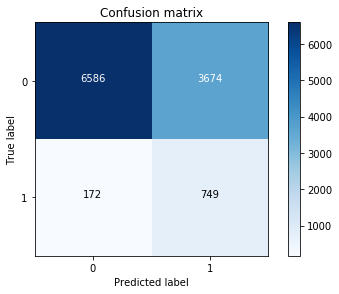

In [23]:
# 实际上这里预测的不逾期的概率， 为了是这里看起来正常， 统统用1减
plot_confusion_matrix(1-y_test.values.ravel(), 1-y_pred, [0,1])

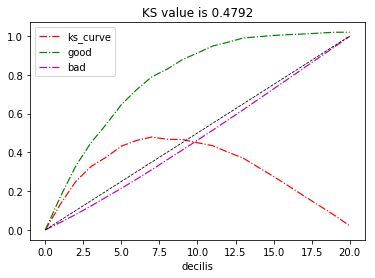

In [24]:
df_ks,_ = ks_stats(y_test.values.ravel(), y_pred)

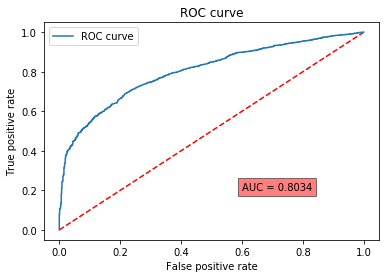

In [25]:
plot_roc_curve(y_test.values.ravel(), y_pred)

## 生成評分卡

In [26]:
def _score_cal(basepoints, odds, PDO):
    """
    cal alpha&beta for score formula, 
    score = alpha + beta * log(odds)
    ---------------------------------------
    Params
    basepoints: expect base points
    odds: cal by logit model
    PDO: points of double odds  
    ---------------------------------------
    Return
    alpha, beta 
    """
    beta = PDO/np.log(2)  
    alpha = basepoints - beta*np.log(odds)
    return alpha, beta

In [27]:
# 按好坏比15为600分，每高20分好坏比翻一倍算出P,Q。
basepoint = 600
PDO = 20
odds = 15
q, p = _score_cal(basepoint, odds, PDO)

In [28]:
p

28.85390081777927

In [29]:
q

521.86218808782962

In [30]:
# 截距
b = lr.intercept_[0]

In [31]:
# 系数
lr.coef_

array([[ 0.93957121, -0.05359666,  0.77562111,  0.65150812,  0.50770733,
         0.19881618,  0.04714561, -0.11148516, -0.02887506, -0.52601164,
         0.52863586, -0.24519365,  0.38491919]])

In [32]:
b

0.11530435451078709

In [33]:
base_score = q + p * b

In [34]:
base_score

525.1891684967419

In [35]:
# 测试样本的B卡得分
test_score = np.dot(x_test.values, lr.coef_.ravel()) * p + q

In [36]:
test_score_df = pd.DataFrame({'customer_id': test_id, 'score':test_score, 'isBad': y_test.values.ravel()})
test_score_df.to_csv('TEST_SCORE.csv', index=False)

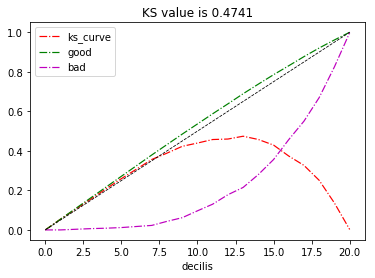

In [44]:
# 同上
df_ks,_ = ks_stats(1-y_test.values.ravel(), 1-test_score)

In [38]:
# 生成评分卡
woe_info.head()

,interval,total,bad,good,bad_pct,good_pct,PctRec,WOE,ori_iv,sum_iv,var_name
0,"(0, 19700)",3844,498.0,3346.0,0.105912,0.065352,0.068763,-0.492228,0.019965,0.649829,quota
1,"(19700, 24800)",5800,861.0,4939.0,0.183114,0.096465,0.103753,-0.646374,0.056007,0.649829,quota
2,"(24800, 30000)",5941,873.0,5068.0,0.185666,0.098984,0.106275,-0.634357,0.054987,0.649829,quota
3,"(30000, 49700)",25800,2312.0,23488.0,0.491706,0.458750,0.461522,-0.071407,0.002353,0.649829,quota
4,"(49700, inf)",14517,158.0,14359.0,0.033603,0.280449,0.259687,2.092460,0.516516,0.649829,quota


In [39]:
coef_dict = dict(zip(list(x_train.columns), list(lr.coef_.ravel())))

In [40]:
# coef_dict

In [41]:
woe_info['score'] = woe_info.apply(lambda row: row['WOE'] * p * coef_dict['%s_woe' % row['var_name']], axis=1)

In [42]:
woe_info.to_csv('SCORE.csv', index=False)